In [1]:
import numpy as np 
import time 
from scipy.optimize import minimize

from ex1_load_mnist import load_mnist
from logistic_regression import logistic_regression
from logistic_regression_vec import logistic_regression_vec
from binary_classifier_accuracy import binary_classifier_accuracy

In [2]:
## Load MNIST data
binary_digits = True
train, test = load_mnist(binary_digits)
train['X'].shape, train['y'].shape, test['X'].shape, test['y'].shape

((784, 12665), (12665,), (784, 2115), (2115,))

In [3]:
train['X'] = np.vstack([np.ones((1, train['X'].shape[1])), train['X']])
test['X']  = np.vstack([np.ones((1, test['X'].shape[1])),  test['X']])

m = train['X'].shape[1]
n = train['X'].shape[0]
(m, n)

(12665, 785)

In [4]:
options = {'maxiter': 100}
theta0 = np.random.rand(n) * 0.001

theta0.shape

(785,)

In [5]:
def objective(t):
    f, g = logistic_regression(t, train['X'], train['y'])
    return f, g

In [6]:
start = time.time()
result = minimize(objective, theta0, jac=True, method='L-BFGS-B', options=options)
theta = result.x
print(f"Optimization took {time.time() - start:.6f} seconds.")
result.message, result.nit

/Users/wesleylu/Desktop/TRADING/dl/ex1/logistic_regression.py:31: RuntimeWarning: divide by zero encountered in log
  f += -yj * np.log(h) - (1 - yj) * np.log(1 - h)
/Users/wesleylu/Desktop/TRADING/dl/ex1/logistic_regression.py:31: RuntimeWarning: invalid value encountered in scalar multiply
  f += -yj * np.log(h) - (1 - yj) * np.log(1 - h)


Optimization took 1.146949 seconds.


('CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL', 16)

In [7]:
train_acc = binary_classifier_accuracy(theta, train['X'], train['y'])
test_acc  = binary_classifier_accuracy(theta, test['X'], test['y'])

print(f"Training accuracy: {100*train_acc:.1f}%")
print(f"Test accuracy: {100*test_acc:.1f}%")

Training accuracy: 100.0%
Test accuracy: 99.9%


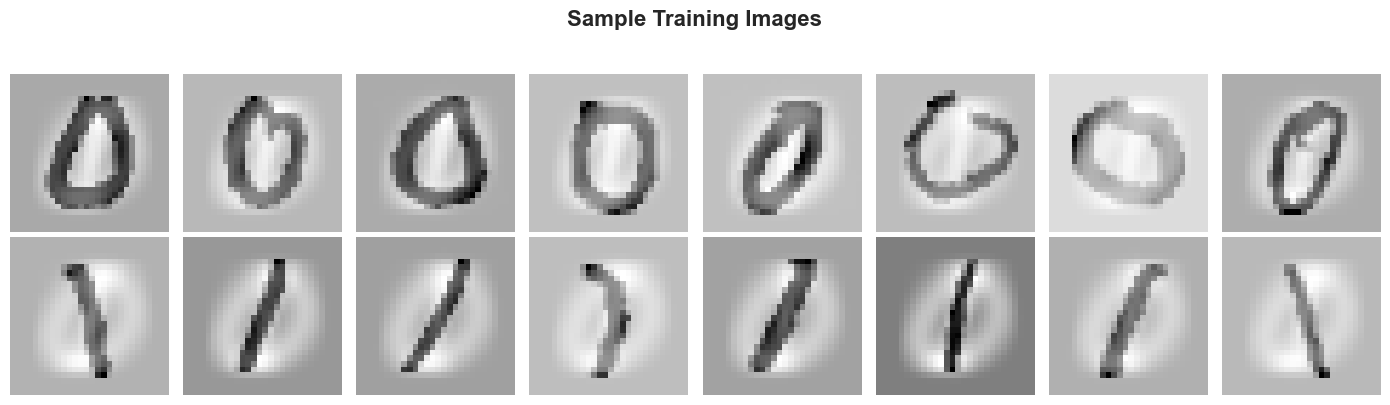

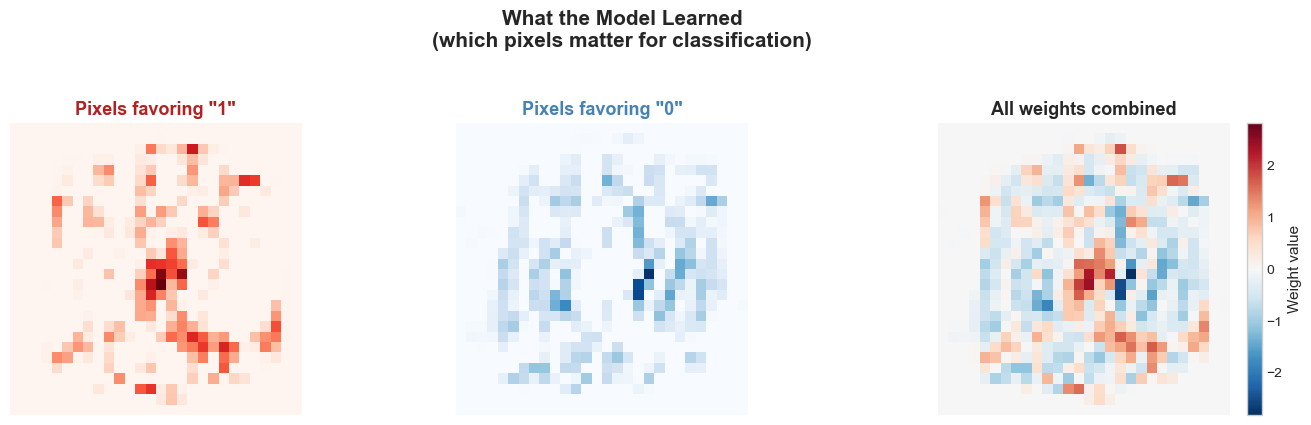

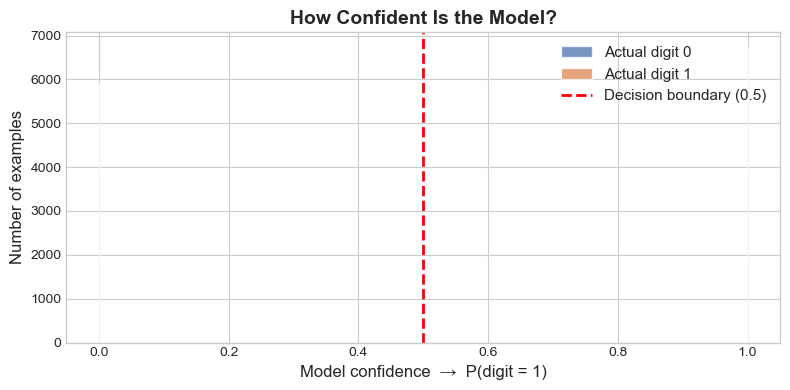

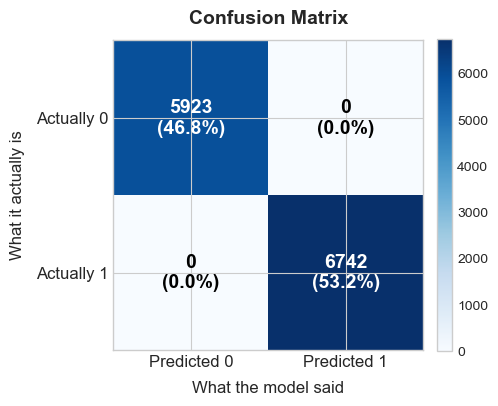

─────────────────────────────────────────────
  Training accuracy:  100.0%
  Test accuracy:      99.9%
  True Positives:     6742   |   False Positives: 0
  True Negatives:     5923   |   False Negatives: 0
─────────────────────────────────────────────


In [10]:
import matplotlib.pyplot as plt
from sigmoid import sigmoid

plt.style.use('seaborn-v0_8-whitegrid')

# ── 1. Sample MNIST digits (separated by class) ──
fig, axes = plt.subplots(2, 8, figsize=(14, 4))
zeros = np.where(train['y'] == 0)[0]
ones  = np.where(train['y'] == 1)[0]
for i in range(8):
    axes[0, i].imshow(train['X'][1:, zeros[i]].reshape(28, 28), cmap='gray_r')
    axes[0, i].axis('off')
    axes[1, i].imshow(train['X'][1:, ones[i]].reshape(28, 28), cmap='gray_r')
    axes[1, i].axis('off')
axes[0, 0].set_ylabel('Digit 0', fontsize=13, fontweight='bold', rotation=0, labelpad=50)
axes[1, 0].set_ylabel('Digit 1', fontsize=13, fontweight='bold', rotation=0, labelpad=50)
fig.suptitle('Sample Training Images', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ── 2. Learned weights heatmap ──
fig, axes = plt.subplots(1, 3, figsize=(14, 4), gridspec_kw={'width_ratios': [1, 1, 1]})

# Positive weights (pushes toward digit 1)
pos_weights = theta[1:].copy().reshape(28, 28)
pos_weights[pos_weights < 0] = 0
axes[0].imshow(pos_weights, cmap='Reds')
axes[0].set_title('Pixels favoring "1"', fontsize=13, fontweight='bold', color='firebrick')
axes[0].axis('off')

# Negative weights (pushes toward digit 0)
neg_weights = theta[1:].copy().reshape(28, 28)
neg_weights[neg_weights > 0] = 0
axes[1].imshow(-neg_weights, cmap='Blues')
axes[1].set_title('Pixels favoring "0"', fontsize=13, fontweight='bold', color='steelblue')
axes[1].axis('off')

# Combined
weight_img = theta[1:].reshape(28, 28)
vmax = np.abs(weight_img).max()
im = axes[2].imshow(weight_img, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[2].set_title('All weights combined', fontsize=13, fontweight='bold')
axes[2].axis('off')
cbar = plt.colorbar(im, ax=axes[2], fraction=0.046, pad=0.04)
cbar.set_label('Weight value', fontsize=11)

fig.suptitle('What the Model Learned\n(which pixels matter for classification)',
             fontsize=15, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

# ── 3. Prediction confidence histogram ──
train_probs = sigmoid(theta @ train['X'])

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(train_probs[train['y'] == 0], bins=40, alpha=0.75, color='#4C72B0',
        edgecolor='white', label='Actual digit 0')
ax.hist(train_probs[train['y'] == 1], bins=40, alpha=0.75, color='#DD8452',
        edgecolor='white', label='Actual digit 1')
ax.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Decision boundary (0.5)')
ax.set_xlabel('Model confidence  →  P(digit = 1)', fontsize=12)
ax.set_ylabel('Number of examples', fontsize=12)
ax.set_title('How Confident Is the Model?', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, framealpha=0.9)
ax.set_xlim(-0.05, 1.05)
plt.tight_layout()
plt.show()

# ── 4. Confusion matrix with percentages ──
train_pred = (train_probs > 0.5).astype(int)
tp = np.sum((train_pred == 1) & (train['y'] == 1))
tn = np.sum((train_pred == 0) & (train['y'] == 0))
fp = np.sum((train_pred == 1) & (train['y'] == 0))
fn = np.sum((train_pred == 0) & (train['y'] == 1))
cm = np.array([[tn, fp], [fn, tp]])
total = cm.sum()

fig, ax = plt.subplots(figsize=(5, 4.5))
im = ax.imshow(cm, cmap='Blues', aspect='equal')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Predicted 0', 'Predicted 1'], fontsize=12)
ax.set_yticklabels(['Actually 0', 'Actually 1'], fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=12)
ax.set_xlabel('What the model said', fontsize=12, labelpad=8)
ax.set_ylabel('What it actually is', fontsize=12, labelpad=8)

for i in range(2):
    for j in range(2):
        pct = 100 * cm[i, j] / total
        label = f'{cm[i, j]}\n({pct:.1f}%)'
        ax.text(j, i, label, ha='center', va='center', fontsize=14, fontweight='bold',
                color='white' if cm[i, j] > cm.max() / 2 else 'black')

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# ── Summary ──
print(f"{'─'*45}")
print(f"  Training accuracy:  {100*train_acc:.1f}%")
print(f"  Test accuracy:      {100*test_acc:.1f}%")
print(f"  True Positives:     {tp}   |   False Positives: {fp}")
print(f"  True Negatives:     {tn}   |   False Negatives: {fn}")
print(f"{'─'*45}")